# Определение возраста покупателей   

*Бизнес-задача*: определить возраст покупателя по фотографии, чтобы в кассовой зоне лучше предлагать товары.  
Побочной задачей является контроль продажи товаров с возрастным цензом.     

*Техническое задание*: модель регрессии для определения возраста по фотографии 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных-и-библиотек" data-toc-modified-id="Загрузка-данных-и-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных и библиотек</a></span></li><li><span><a href="#Исследование-данных" data-toc-modified-id="Исследование-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Исследование данных</a></span></li><li><span><a href="#Предварительные-выводы" data-toc-modified-id="Предварительные-выводы-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Предварительные выводы</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#Код--обучения-модели" data-toc-modified-id="Код--обучения-модели-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Код  обучения модели</a></span></li><li><span><a href="#Результат-работы-модели" data-toc-modified-id="Результат-работы-модели-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Результат работы модели</a></span></li><li><span><a href="#Промежуточный-итог" data-toc-modified-id="Промежуточный-итог-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Промежуточный итог</a></span></li></ul></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

## Исследовательский анализ данных

### Загрузка данных и библиотек

In [6]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [7]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255) 
train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels, directory='/datasets/faces/final_files/', 
                                                   x_col='file_name', y_col='real_age', target_size=(224, 224), 
                                                   batch_size=32, class_mode='raw', seed=12345)

Found 7591 validated image filenames.


### Исследование данных    
  
  
Размер датасета:

In [8]:
print(labels.shape)

(7591, 2)


Распределение по возрастам:

<AxesSubplot:>

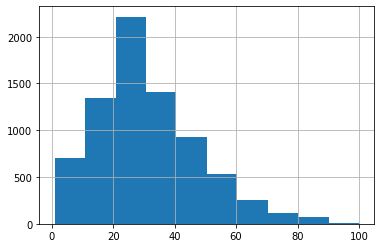

In [9]:
labels['real_age'].hist(bins=100)

Посмотрим, как выглядит датафрейм:

In [10]:
print(labels.head(4))

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50


Как выглядят необработанные картинки в нём:

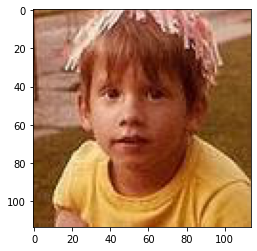

In [11]:
image = Image.open('/datasets/faces/final_files/000000.jpg')
array = np.array(image)
plt.imshow(array)
plt.show()

Посмотрим на изображения после импорта и рескейла.  
Одну подробно и 24 подряд

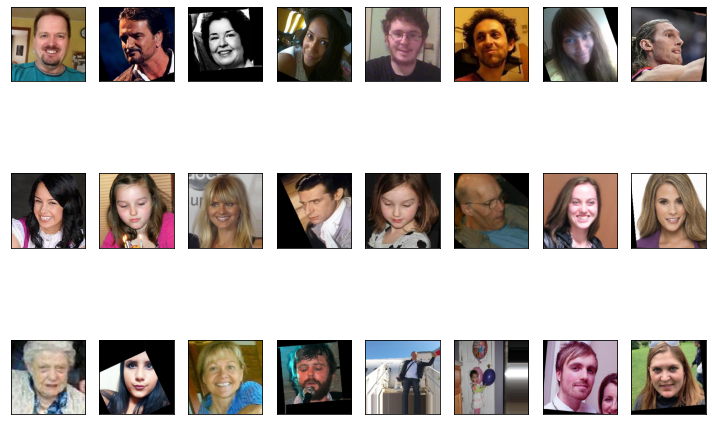

In [12]:
fig = plt.figure(figsize=(10,10))
for i in range(24):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(train_gen_flow[i][0][0])

    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


### Предварительные выводы  
  
 - датасет хорошо представлен в возрастах 15 - 60 и хуже в других. Соотвественно, вне этого диапазона будут сложности с определением  
 - датасет имеет фото как в анфас, так в профиль. Однако, вторых больше - они должны классифицироваться лучше. 
 - в датасете есть фото где больше одного человека.

## Обучение модели

### Код  обучения модели    
Параметры модели:  
- `epochs` = 15 / уже на 4й эпохе был достигнут целевой показатель  
- `lr` = 0.0001 / параметр оптимизации Adam небольшой именно поэтому было взято достаточно много эпох.   
- `loss` - оценивается по среднеквадратической ошибке.  
Модель имеет дополнительный слой с 84 нейроманами `Flatten` передним. 

```python

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd


def load_train(path):
    file_path = str(path) + 'labels.csv'
    df = pd.read_csv(file_path)
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df, directory=path+'final_files/',  x_col='file_name', y_col='real_age',target_size=(224, 224), batch_size=16, class_mode='raw', subset='training',  seed=12345)
    return train_datagen_flow

def load_test(path):
    file_path = str(path) + '/labels.csv'
    df = pd.read_csv(file_path)
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=df, directory=path+'final_files/', x_col='file_name', y_col='real_age', target_size=(224, 224), batch_size=16, class_mode='raw', subset='validation',  seed=12345)
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    #backbone.trainable = False
    model = Sequential()
    model.add(backbone)
    model.add(Flatten())
    model.add(Dense(units=84, activation='relu'))
    #model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model
    
def train_model (model, train_data, test_data, batch_size=None, epochs=15,steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, validation_data=test_data, batch_size=batch_size, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2)
    return model

```

### Результат работы модели  
Финальный результат: Test MAE: 6.8766

```
Train for 356 steps, validate for 119 steps
Epoch 1/15
2022-12-16 20:00:49.256728: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-12-16 20:00:49.555769: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 68s - loss: 191.2550 - mae: 10.5547 - val_loss: 331.8148 - val_mae: 13.5767
Epoch 2/15
356/356 - 43s - loss: 101.2678 - mae: 7.5596 - val_loss: 226.6213 - val_mae: 12.3349
Epoch 3/15
356/356 - 43s - loss: 63.4332 - mae: 6.0081 - val_loss: 122.0177 - val_mae: 8.5127
Epoch 4/15
356/356 - 44s - loss: 49.4949 - mae: 5.2145 - val_loss: 91.3222 - val_mae: 7.2837
Epoch 5/15
356/356 - 44s - loss: 38.2202 - mae: 4.6427 - val_loss: 86.0708 - val_mae: 7.1990
Epoch 6/15
356/356 - 45s - loss: 33.3413 - mae: 4.2906 - val_loss: 92.4105 - val_mae: 7.2909
Epoch 7/15
356/356 - 46s - loss: 27.2771 - mae: 3.8964 - val_loss: 79.1107 - val_mae: 6.6399
Epoch 8/15
356/356 - 44s - loss: 27.4091 - mae: 3.8333 - val_loss: 84.4086 - val_mae: 7.1155
Epoch 9/15
356/356 - 45s - loss: 26.1073 - mae: 3.8355 - val_loss: 88.8530 - val_mae: 7.3254
Epoch 10/15
356/356 - 44s - loss: 23.7827 - mae: 3.6866 - val_loss: 76.9306 - val_mae: 6.7048
Epoch 11/15
356/356 - 44s - loss: 23.3395 - mae: 3.5831 - val_loss: 89.0075 - val_mae: 7.2032
Epoch 12/15
356/356 - 44s - loss: 22.8819 - mae: 3.6080 - val_loss: 84.2356 - val_mae: 7.1714
Epoch 13/15
356/356 - 45s - loss: 23.1172 - mae: 3.6202 - val_loss: 88.1714 - val_mae: 7.1706
Epoch 14/15
356/356 - 45s - loss: 22.7999 - mae: 3.5848 - val_loss: 90.7639 - val_mae: 7.0145
Epoch 15/15
356/356 - 44s - loss: 21.8156 - mae: 3.4509 - val_loss: 80.3244 - val_mae: 6.8766
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 80.3244 - mae: 6.8766

```
**Test MAE: 6.8766**

### Промежуточный итог  
Была обучена модель на основе ResNet. Модель может быть оптимизирована и сокращен срок обучения до 4 - 10 эпох. 

## Анализ обученной модели

Модель имеет точность по средней абсолютной ошибке около 6.87 года.  
Учитывая репрезентативность данных, побочная бизнес-задача не решена - точно отделить 15-летнего человека от 18-летнего практически не возможно, теме более 17-летнего от 18-летнего.  
При этом, это достаточная точность для опредлеения сегмента аудитории и тагретированного предложения. 
Модель может быть оптимизирована и может быть дообучена в процессе экспулатации

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы